# 第4部　Box-Jenkins法とその周辺

## 第4章　モデル選択

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
import pmdarima as pm

# 予測
from sktime.forecasting.arima import AutoARIMA

# 予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error, MeanAbsoluteError,
    mean_absolute_percentage_error, mean_absolute_error
)

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [3]:
# データの読み込み
ts_sales_bj = pd.read_csv(
    '4-3-1-sales-data.csv',  # ファイル名
    index_col='date',        # インデックスとして扱う列名
    parse_dates=True,        # インデックスを「時間軸」として扱う
    dtype='float'            # データの型(浮動小数点)
)

ts_sales_bj.index.freq = 'MS'

# 訓練データとテストデータに分割する
train = ts_sales_bj.loc['2010-01':'2018-12']
test =  ts_sales_bj.loc['2019-01':'2019-12']

### 単位根検定の実装

#### 間違った差分の階数の判断方法

In [4]:
# これは間違い
pm.arima.ndiffs(np.log(train['sales']), test='kpss')

1

In [5]:
# これは間違い
pm.arima.nsdiffs(np.log(train['sales']), m=12, test='ocsb')

0

#### 正しい判断の方法

In [6]:
# 残差の取得
ols_resid = smf.ols('np.log(sales) ~ discount', data=train).fit().resid
# 確認
ols_resid.head(3)

date
2010-01-01   -0.025589
2010-02-01   -0.083576
2010-03-01   -0.129386
dtype: float64

In [7]:
# 残差に対して適用する
pm.arima.ndiffs(ols_resid, test='kpss')

1

In [8]:
# 残差に対して適用する
pm.arima.nsdiffs(ols_resid, m=12, test='ocsb')

1

### 自動予測アプローチの実践

#### 半自動モデル選択の実行

In [9]:
mod_sarimax_best = pm.arima.auto_arima(
    y = np.log(train['sales']),                  # データ
    X = train['discount'].values.reshape(-1,1),  # 外生変数
    test='kpss',              # KPSS検定で、差分をとる階数を決める
    seasonal_test='ocsb',     # OCSB検定で、季節差分をとる階数を決める
    criterion='AIC',          # AICで変数選択
    m=12,                     # 周期は12
    max_p=2, max_q=2, max_P=2, max_Q=2,              # 最大次数
    start_p=0, start_q=0, start_Q=0, start_P=0,      # 開始次数
    stepwise=False,          # 総当たりでAICを比較
    n_jobs=-1,               # 使える限りのコアを使って並列化 
    maxiter=5000,            # パラメータ推定のときの設定(反復回数を5000回に増やす)
    with_intercept=False,    # 切片なしのモデルにする
    solver='nm'              # パラメータ推定のときの設定(最適化の手法を変更)
)

In [10]:
print(mod_sarimax_best.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  77.949
Date:                            Wed, 11 Sep 2024   AIC                           -149.898
Time:                                    16:46:31   BIC                           -142.236
Sample:                                01-01-2010   HQIC                          -146.802
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7762      0.023     33.211      0.000       0.730       0.822
ar.L1         -0.4454      0.087   

#### (参考)モデルのリストを取得

In [11]:
# 参考：モデルのリストを取得
mod_sarimax_list = pm.arima.auto_arima(
    y = np.log(train['sales']),                  # データ
    X = train['discount'].values.reshape(-1,1),  # 外生変数
    test='kpss',              # KPSS検定で、差分をとる階数を決める
    seasonal_test='ocsb',     # OCSB検定で、季節差分をとる階数を決める
    criterion='AIC',          # AICで変数選択
    m=12,                     # 周期は12
    max_p=2, max_q=2, max_P=2, max_Q=2,              # 最大次数
    start_p=0, start_q=0, start_Q=0, start_P=0,      # 開始次数
    stepwise=False,          # 総当たりでAICを比較
    n_jobs=-1,               # 使える限りのコアを使って並列化 
    maxiter=5000,            # パラメータ推定のときの設定(反復回数を5000回に増やす)
    with_intercept=False,    # 切片なしのモデルにする
    solver='nm',             # パラメータ推定のときの設定(最適化の手法をNelder-Mead法に変更)
    return_valid_fits=True   # すべての結果を保持
)

In [12]:
# モデル事にAICとセットでDataFrameにまとめる
result_df = pd.DataFrame({
    'model': np.tile('', len(mod_sarimax_list)),
    'AIC'  : np.zeros(len(mod_sarimax_list))
})

for i in range(0,len(mod_sarimax_list)):
    result_df.iloc[i, 0] = str(mod_sarimax_list[i])
    result_df.iloc[i, 1] = mod_sarimax_list[i].aic()

# AICが小さいものから順に表示
print(result_df.sort_values('AIC'))

                                 model         AIC
0    ARIMA(1,1,0)(0,1,0)[12]           -149.897609
1    ARIMA(0,1,1)(0,1,0)[12]           -149.043075
2    ARIMA(1,1,1)(0,1,0)[12]           -148.459464
3    ARIMA(0,1,2)(0,1,0)[12]           -148.440133
4    ARIMA(2,1,0)(0,1,0)[12]           -148.364485
5    ARIMA(1,1,0)(0,1,1)[12]           -148.313625
6    ARIMA(1,1,0)(1,1,0)[12]           -148.310738
7    ARIMA(0,1,1)(0,1,1)[12]           -147.510976
8    ARIMA(0,1,1)(1,1,0)[12]           -147.487736
9    ARIMA(1,1,1)(0,1,1)[12]           -146.706143
10   ARIMA(1,1,1)(1,1,0)[12]           -146.702858
11   ARIMA(0,1,2)(0,1,1)[12]           -146.677925
12   ARIMA(0,1,2)(1,1,0)[12]           -146.676054
13   ARIMA(2,1,0)(0,1,1)[12]           -146.634326
14   ARIMA(2,1,0)(1,1,0)[12]           -146.631508
15   ARIMA(1,1,2)(0,1,0)[12]           -146.444433
16   ARIMA(2,1,1)(0,1,0)[12]           -146.439378
17   ARIMA(1,1,0)(2,1,0)[12]           -146.349422
18   ARIMA(1,1,0)(0,1,2)[12]   

### モデルの診断

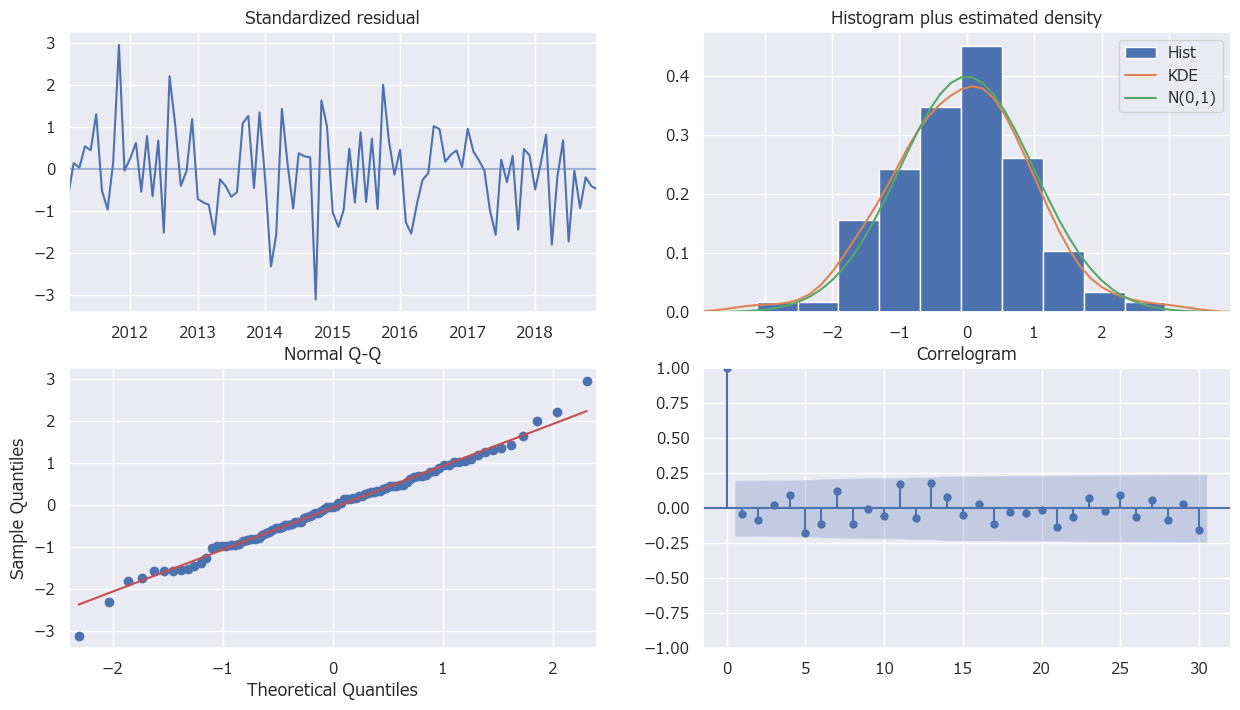

In [13]:
# 残差診断
_ = mod_sarimax_best.plot_diagnostics(lags=30, figsize=(15, 8))

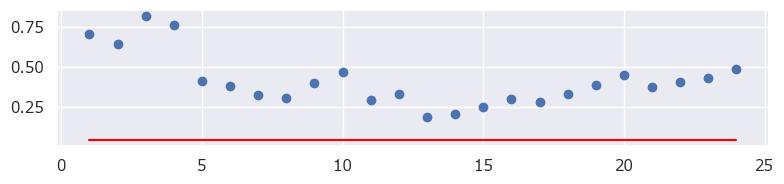

In [14]:
# 残差の自己相関の検定
# 1時点前から24時点前まで、1つずつ最大次数をずらして、24回検定を行う
res_test = mod_sarimax_best.arima_res_.test_serial_correlation(
    method='ljungbox', lags=24)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# p値のグラフを描画
ax.scatter(np.arange(1,25), res_test[0][1])

# 高さ0.05の位置に赤線を引く
ax.plot(np.arange(1,25), np.tile(0.05, 24), color='red')

In [15]:
# 残差の正規性の検定(Jarque-Bera検定)
# 1つ目がJB統計量
# 2つ目がp値
# 3つ、4つ目が歪度と尖度
mod_sarimax_best.arima_res_.test_normality(method='jarquebera')

array([[ 1.3298735 ,  0.51430606, -0.0148029 ,
         3.57887092]])

### sktimeを利用する方法

In [16]:
# 予測期間
fh = np.arange(1, len(test) + 1)

# データの変換
train_period = train.to_period()
test_period = test.to_period()

In [17]:
# 予測手法の指定
arima_forecaster = AutoARIMA(
    test='kpss',                   # KPSS検定で、差分を取る階数を決める
    seasonal_test='ocsb',          # OCSB検定で、季節差分をとる階数を決める
    information_criterion='aic',   # AICで変数選択
    sp=12,                         # 周期は12
    max_p=2, max_q=2, max_P=2, max_Q=2,              # 最大次数
    start_p=0, start_q=0, start_Q=0, start_P=0,      # 開始次数
    stepwise=False,          # 総当たりでAICを比較
    n_jobs=-1,               # 使える限りのコアを使って並列化 
    maxiter=5000,            # パラメータ推定のときの設定(反復回数を5000回に増やす)
    with_intercept=False,    # 切片なしのモデルにする
    method='nm'              # パラメータ推定のときの設定(最適化の手法を変更)
)

# データへの当てはめ
arima_forecaster.fit(y=np.log(train_period['sales']),
                     X=train_period['discount'])

AutoARIMA(max_p=2, max_q=2, maxiter=5000, method='nm', n_jobs=-1, sp=12,
          start_P=0, start_Q=0, start_p=0, start_q=0, stepwise=False,
          with_intercept=False)

In [18]:
# 予測の実施
sarimax_fore = arima_forecaster.predict(fh, X=test_period['discount'])

# 予測精度
mean_absolute_error(test_period['sales'], sarimax_fore)

25.240766610356218